In [10]:
import os
import sys
sys.path.append('..')
import numpy as np
import json
import imageio.v2 as iio
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch.nn import functional as F
from utils.layers import Project3D, BackprojectDepth

batch_size, T = 1, 1
cam_K = torch.tensor([[0.82, 0, 0.5, 0],
            [0, 1.02, 0.5, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1]]).float().reshape(1,4,4)

data_root = '/data_hdd2/users/zhouzanwei/data/Medical/SCARED/scared/train/dataset1/keyframe1/data'
rgb_paths, depth_paths, pose_paths, Ks = [], [], [], []
for img_id in [0, 100]:
    rgb_paths.append(os.path.join(data_root, 'left', f'{img_id:010d}.png'))
    depth_paths.append(os.path.join(data_root, 'scene_points', f'scene_points{img_id:06d}.tiff'))
    pose_paths.append(os.path.join(data_root, 'frame_data', f'frame_data{img_id:06d}.json'))
imgs = [iio.imread(p) for p in rgb_paths]
depths = [cv2.imread(depth_path, 3).astype(np.float32)[0:1024, :, 0] for depth_path in depth_paths]
poses = []
for pose_path in pose_paths:
    with open(pose_path, 'r') as path:
        data = json.load(path)
        poses.append(np.array(data['camera-pose'])) # w2c
        Ks.append(torch.tensor(data["camera-calibration"]["KL"]).float())
h, w = imgs[0].shape[:2]
cam_K[:, 0, :] *= w
cam_K[:, 1, :] *= h
inv_K = torch.from_numpy(np.linalg.pinv(cam_K.numpy()))
backproject_depth = BackprojectDepth(batch_size*T, h, w)
project_3d = Project3D(batch_size*T, h, w)

In [11]:
depths = [depth / 2 for depth in depths]

In [12]:
src_depth = torch.from_numpy(depths[0]).float().unsqueeze(0).unsqueeze(0)
tgt_depth = torch.from_numpy(depths[1]).float().unsqueeze(0).unsqueeze(0)
T = torch.from_numpy(poses[1] @ np.linalg.pinv(poses[0])).float().unsqueeze(0)
src_img = torch.from_numpy(imgs[0]).float().permute(2, 0, 1).unsqueeze(0)
tgt_img = torch.from_numpy(imgs[1]).float().permute(2, 0, 1).unsqueeze(0)
cam_K = torch.zeros(1, 4, 4).float()
cam_K[0, 3, 3] = 1.
cam_K[0, :3, :3] = Ks[1]
inv_K = torch.zeros(1, 4, 4).float()
inv_K[0, 3, 3] = 1.
inv_K[0, :3, :3] = Ks[0]
inv_K = torch.inverse(inv_K)

cam_points = backproject_depth(src_depth, inv_K)
pix_coords, _ = project_3d(cam_points, cam_K, T)
P = torch.matmul(cam_K, T)[:, :3, :]
proj_points = torch.matmul(P, cam_points) # [1, 4, N]
src_proj_depth = proj_points[0, 2, :].reshape(h, w).numpy() # [1, 1, N]
projected_img = F.grid_sample(
                    tgt_img,
                    pix_coords,
                    padding_mode="border",
                    align_corners=True)
projected_img = projected_img.squeeze(0).permute(1, 2, 0).numpy().astype(np.uint8)
tgt_proj_depth = F.grid_sample(
                    tgt_depth,
                    pix_coords,
                    padding_mode="border",
                    align_corners=True)
tgt_proj_depth = tgt_proj_depth.squeeze(0).squeeze(0).numpy()


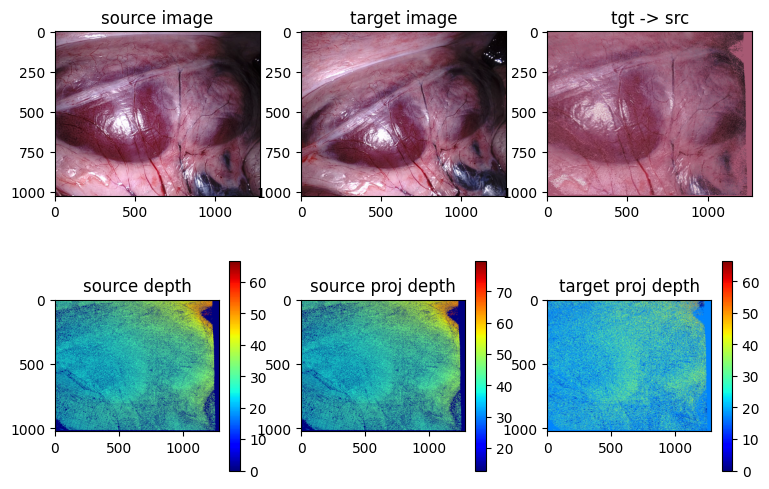

In [13]:
plt.figure(figsize=(9, 6))
ax = plt.subplot(2, 3, 1)
plt.imshow(imgs[0])
ax.set_title("source image")
ax = plt.subplot(2, 3, 2)
plt.imshow(imgs[1])
ax.set_title("target image")
ax = plt.subplot(2, 3, 3)
plt.imshow(projected_img)
ax.set_title("tgt -> src")
ax = plt.subplot(2, 3, 4)
plt.imshow(depths[0], cmap='jet')
plt.colorbar()
ax.set_title("source depth")
ax = plt.subplot(2, 3, 5)
plt.imshow(src_proj_depth, cmap='jet')
plt.colorbar()
ax.set_title("source proj depth")
ax = plt.subplot(2, 3, 6)
plt.imshow(tgt_proj_depth, cmap='jet')
plt.colorbar()
ax.set_title("target proj depth")
plt.show()

In [4]:
def pcwrite(filename, xyzrgb):
    """Save a point cloud to a polygon .ply file.
    """
    xyz = xyzrgb[:, :3]
    rgb = xyzrgb[:, 3:].astype(np.uint8)

    # Write header
    ply_file = open(filename,'w')
    ply_file.write("ply\n")
    ply_file.write("format ascii 1.0\n")
    ply_file.write("element vertex %d\n"%(xyz.shape[0]))
    ply_file.write("property float x\n")
    ply_file.write("property float y\n")
    ply_file.write("property float z\n")
    ply_file.write("property uchar red\n")
    ply_file.write("property uchar green\n")
    ply_file.write("property uchar blue\n")
    ply_file.write("end_header\n")

    # Write vertex list
    for i in range(xyz.shape[0]):
        ply_file.write("%f %f %f %d %d %d\n"%(
        xyz[i, 0], xyz[i, 1], xyz[i, 2],
        rgb[i, 0], rgb[i, 1], rgb[i, 2],
        ))

xyzs = cam_points[0, :3].permute(1,0).numpy()
colors = np.zeros_like(xyzs) + 125
pcwrite('test.ply', np.concatenate([xyzs, colors], axis=1))

In [24]:
cam_points.shape

torch.Size([1, 4, 1310720])

In [14]:
h*w

1310720

In [10]:
projected_img.shape

(1024, 1280, 3)